In [1]:
import numpy as np
from pathlib import Path
import shutil
import warnings

from nifreeze.data import pet
from nifreeze.model import PETModel
#from eddymotion.viz import plot_dwi
import nibabel as nib
from nifreeze.data.splitting import lovo_split
from pathlib import Path

In [2]:
base_dir = Path("/Users/martinnorgaard/Downloads/eddymotion_pet_testdata/")
bids_dir = base_dir / "data"
derivatives_dir = base_dir / "nifreeze"

pet_file = bids_dir / "sub-02" / "ses-baseline" / "pet" / "sub-02_ses-baseline_pet.nii.gz"
json_file = bids_dir / "sub-02" / "ses-baseline" / "pet" / "sub-02_ses-baseline_pet.json"

pet_dataset = pet.PET.load(pet_file, json_file)

In [3]:
pet_dataset

PET(dataobj=<128x128x90x21 (float32)>, affine=<4x4 (float64)>, brainmask=None, motion_affines=None, datahdr=None, midframe=<21 (float64)>, total_duration=7200.066)

In [31]:
data_train, data_test = pet_dataset.lofo_split(15)

In [34]:
data_train[0]

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [35]:
model = PETModel(dataset=pet_dataset, timepoints=data_train[1], xlim=7000)

In [36]:
model.fit(data_train[0])

In [37]:
predicted = model.predict(data_test[1])

In [24]:
# before
nifti_img_before = nib.Nifti1Image(predicted, pet_dataset.affine)
output_path_before = 'before_mc.nii'
nifti_img_before.to_filename(output_path_before)

# after
nifti_img_after = nib.Nifti1Image(data_test[0], pet_dataset.affine)
output_path_after = 'after_mc.nii'
nifti_img_after.to_filename(output_path_after)

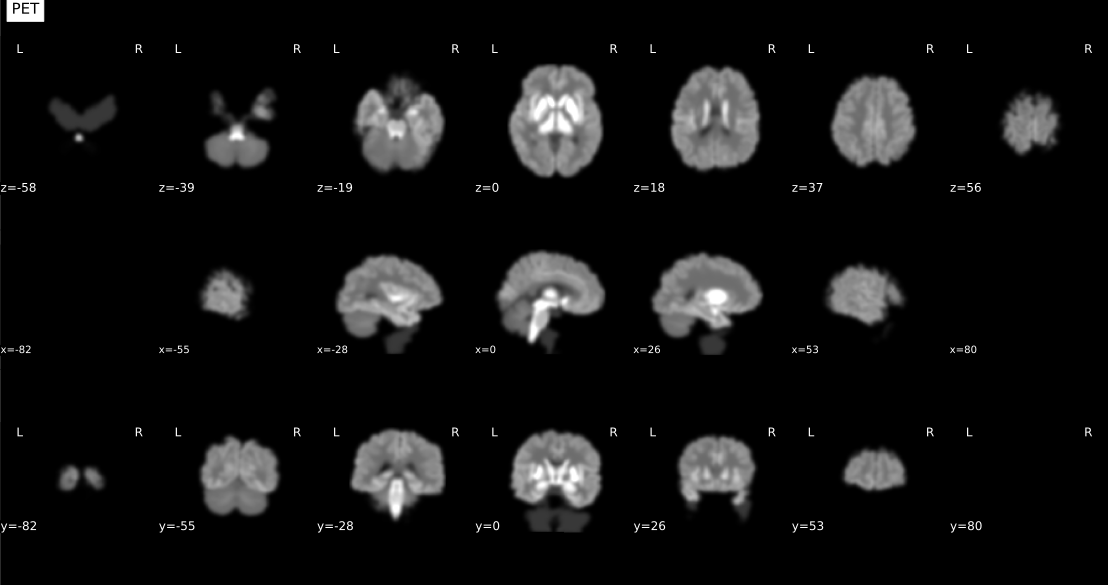

In [25]:
from niworkflows.viz.notebook import display
import os
from IPython.display import SVG

moving_image = output_path_after
fixed_image = output_path_before
obj = display(fixed_image, moving_image, fixed_label='PET_before', moving_label='PET')

In [5]:
from nifreeze.estimator import PETMotionEstimator

In [ ]:
debug_output_path = "/Users/martinnorgaard/Downloads/eddymotion_pet_testdata/nifreeze/"

# Instantiate with a PETModel or appropriate model instance
model = PETModel(dataset=pet_dataset, timepoints=pet_dataset.midframe, xlim=pet_dataset.total_duration)
estimator = PETMotionEstimator(model=model)

# Run the estimator
affines = estimator.run(
    pet_dataset,
    omp_nthreads=4,
    n_jobs=4,
    debug_dir=debug_output_path
)

/Users/martinnorgaard/Dropbox/Mac/Documents/GitHub/nifreeze/src/nifreeze/model/pet.py:57: UserWarning: No mask provided; consider using a mask to avoid issues in model optimization.
  super().__init__(**kwargs)
Estimating PET motion:   5%|████████▊                                                                                                                                                                                | 1/21 [02:51<57:07, 171.36s/it]

In [15]:
affines

[array([[ 9.94606238e-01,  4.10106127e-02,  1.62648185e-01,
          3.10046448e-01],
        [ 1.18421999e-01,  8.08318764e-01,  1.39511365e-01,
          6.26920997e+00],
        [-5.57126759e-02,  1.62871672e-03,  8.69893760e-01,
          7.02765683e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 1.00670371,  0.01383463, -0.01138899, -3.91627243],
        [-0.01482363,  1.00288485, -0.0283763 ,  2.86055659],
        [ 0.02314622,  0.02035951,  1.02977958,  9.97315409],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[  1.00643467,  -0.04328718,  -0.03102227, -13.5191133 ],
        [  0.0416959 ,   1.00592362,  -0.03325968,   8.01194562],
        [  0.03313941,   0.02435314,   1.02218514,   9.81956481],
        [  0.        ,   0.        ,   0.        ,   1.        ]]),
 array([[ 0.99602643, -0.01095334, -0.01914344,  1.86458968],
        [ 0.01194554,  1.00532518,  0.02333777,  1.25571696],
        [ 

In [19]:
import numpy as np
import pandas as pd

def extract_motion_parameters(affine):
    """Extract translation (mm) and rotation (degrees) parameters from an affine matrix."""
    translation = affine[:3, 3]
    rotation_rad = np.arctan2(
        [affine[2, 1], affine[0, 2], affine[1, 0]],
        [affine[2, 2], affine[0, 0], affine[1, 1]]
    )
    rotation_deg = np.rad2deg(rotation_rad)
    return (*translation, *rotation_deg)

def compute_fd(motion_parameters):
    """Compute Framewise Displacement from motion parameters."""
    translations = motion_parameters[:, :3]
    rotations_deg = motion_parameters[:, 3:]
    rotations_rad = np.deg2rad(rotations_deg)
    
    # Compute differences between consecutive frames
    d_translations = np.vstack([np.zeros((1, 3)), np.diff(translations, axis=0)])
    d_rotations = np.vstack([np.zeros((1, 3)), np.diff(rotations_rad, axis=0)])
    
    # Convert rotations from radians to displacement on a sphere (radius 50 mm)
    radius = 50  # typical head radius in mm
    rotation_displacement = d_rotations * radius
    
    # Compute FD as sum of absolute differences
    fd = np.sum(np.abs(d_translations) + np.abs(rotation_displacement), axis=1)
    return fd

# Assume 'affines' is the list of affine matrices you computed earlier
motion_parameters = []

for idx, affine in enumerate(affines):
    tx, ty, tz, rx, ry, rz = extract_motion_parameters(affine)
    motion_parameters.append([tx, ty, tz, rx, ry, rz])

motion_parameters = np.array(motion_parameters)
fd = compute_fd(motion_parameters)

# Creating a DataFrame for better visualization
df_motion = pd.DataFrame({
    "Frame": np.arange(len(fd)),
    "Translation X (mm)": motion_parameters[:, 0],
    "Translation Y (mm)": motion_parameters[:, 1],
    "Translation Z (mm)": motion_parameters[:, 2],
    "Rotation X (deg)": motion_parameters[:, 3],
    "Rotation Y (deg)": motion_parameters[:, 4],
    "Rotation Z (deg)": motion_parameters[:, 5],
    "Framewise Displacement (mm)": fd
})

# Save to TSV file
df_motion.to_csv('motion_parameters.tsv', sep='\t', index=False)

In [2]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 10))

# Translation plots
plt.subplot(2, 3, 1)
sns.lineplot(x='Frame', y='Translation X', data=df_motion)
plt.title('Translation X over Frames')

plt.subplot(2, 3, 2)
sns.lineplot(x='Frame', y='Translation Y', data=df_motion)
plt.title('Translation Y over Frames')

plt.subplot(2, 3, 3)
sns.lineplot(x='Frame', y='Translation Z', data=df_motion)
plt.title('Translation Z over Frames')

# Rotation plots
plt.subplot(2, 3, 4)
sns.lineplot(x='Frame', y='Rotation X (deg)', data=df_motion)
plt.title('Rotation X over Frames')

plt.subplot(2, 3, 5)
sns.lineplot(x='Frame', y='Rotation Y (deg)', data=df_motion)
plt.title('Rotation Y over Frames')

plt.subplot(2, 3, 6)
sns.lineplot(x='Frame', y='Rotation Z (deg)', data=df_motion)
plt.title('Rotation Z over Frames')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined